# Speech Emotion Recognition
LT2316 Course Project by Merle Pfau

In [1]:
import soundfile
import os, pickle
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import torch
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import librosa
from model import LSTM_fixed_len as model
from model import Trainer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sn
import IPython
import random

In [2]:
#set up trainer
model_dump = "project_models/" 
trainer = Trainer(dump_folder=model_dump) 

In [3]:
#function to extract the features "pitch" (chroma), "mfccs" and "mel"
#inspired by this tutorial: https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/
#and this paper: https://github.com/terranivium/speech-emotion-recognition/blob/master/speech_emotion_recognition.ipynb
def extract_feature(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32") # all depth 32bit float
        sample_rate = sound_file.samplerate # always 16kHz
        
        # pre-emphasis
        pre_emphasis = 0.97
        X = np.append(X[0], X[1:] - pre_emphasis * X[:-1])

        # remove silence
        y = librosa.effects.split(X, top_db=20)
        l = []
        for i in y:
            l.append(X[i[0]:i[1]] )
        X = np.concatenate(l, axis=0)
        
        # extract features
        stft=np.abs(librosa.stft(X))
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        mfccs=np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=40).T,axis=0)
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result=np.hstack((mfccs, chroma))
    result = np.hstack((result, mel))
    return result

In [4]:
emotions={
  0:'neutral',
  1:'calm',
  2:'happy',
  3:'sad',
  4:'angry',
  5:'fearful',
  6:'disgust',
  7:'surprised'
}

In [5]:
X,y=[],[]
all_files = Path("Audio_Speech_Actors_01-24")

for file in all_files.glob("Actor_*/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = basename.split("-")[2]
    emotion = emotion.replace('0','')
    emotion = int(emotion)-1
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    y.append(emotion)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=3)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1765, random_state=3)

In [7]:
x_train, x_test, x_val, y_train, y_test, y_val = torch.Tensor(x_train), torch.Tensor(x_test), torch.Tensor(x_val), torch.LongTensor(y_train),  torch.LongTensor(y_test), torch.LongTensor(y_val)

In [8]:
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


## Data Visualization 

Number of samples:  1440


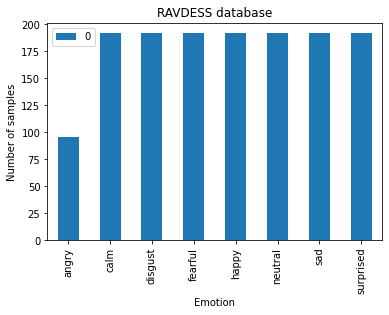

In [9]:
y_ct = Counter(y)
number_of_samples = len(y)
print("Number of samples: ", number_of_samples)
keys = [emotions[y] for y in list(y_ct.keys())]
data = y_ct.values()
keys.sort()
to_plot= pd.DataFrame(data,index=keys)
to_plot.plot.bar()

plt.xlabel("Emotion")
plt.ylabel("Number of samples")
plt.title("RAVDESS database")
plt.show()

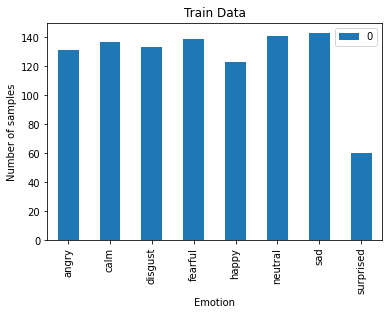

In [10]:
y_train_ct = Counter(y_train.tolist())

keys = [emotions[y] for y in list(y_train_ct.keys())]
data = y_train_ct.values()
keys.sort()
to_plot= pd.DataFrame(data,index=keys)
to_plot.plot.bar()

plt.xlabel("Emotion")
plt.ylabel("Number of samples")
plt.title("Train Data")
plt.show()

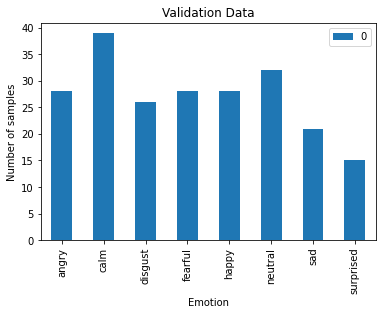

In [11]:
y_val_ct = Counter(y_val.tolist())

keys = [emotions[y] for y in list(y_val_ct.keys())]
data = y_val_ct.values()
keys.sort()
to_plot= pd.DataFrame(data,index=keys)
to_plot.plot.bar()

plt.xlabel("Emotion")
plt.ylabel("Number of samples")
plt.title("Validation Data")
plt.show()

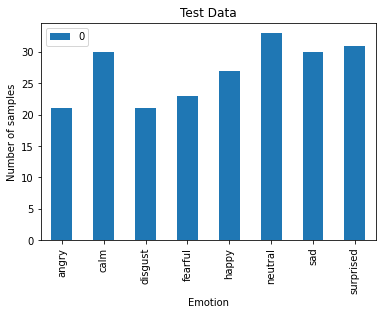

In [12]:
y_test_ct = Counter(y_test.tolist())

keys = [emotions[y] for y in list(y_test_ct.keys())]
data = y_test_ct.values()
keys.sort()
to_plot= pd.DataFrame(data,index=keys)
to_plot.plot.bar()

plt.xlabel("Emotion")
plt.ylabel("Number of samples")
plt.title("Test Data")
plt.show()

## Hyperameter Selection

In [13]:
output_size=len(list(emotions.keys()))

set_hyperparameters = [{"learning_rate": 0.001,
                        "hidden_size": 100,
                        "number_layers": 3,
                        "batch_size": 150,
                        "model": 'model1'
                        },
                       {"learning_rate": 0.001,
                        "hidden_size": 400,
                        "number_layers": 3,
                        "batch_size": 32,
                        "model": 'model2'
                       },
                       {"learning_rate": 0.001,
                        "hidden_size": 250,
                        "number_layers": 2,
                        "batch_size": 64,
                        "model": 'model3'
                       },
                        {"learning_rate": 0.001,
                         "hidden_size": 250,
                         "number_layers": 3,
                         "batch_size": 64,
                         "model": 'model4'
                        },
                       {"learning_rate": 0.001,
                        "hidden_size": 250,
                        "number_layers": 3,
                        "batch_size": 32,
                        "model": 'model5'
                       },
                       {"learning_rate": 0.001,
                        "hidden_size": 250,
                        "number_layers": 2,
                        "batch_size": 32,
                        "model": 'model6'
                       }
                      ]

In [14]:
for hp in set_hyperparameters:
    trainer.train_model(model, x_train, y_train, x_val, y_val, hp, output_size)

no old model found
model1: Total loss in epoch 99 is: 5.958897113800049      |      F1 score in validation is: 0.551399031040712936
 Finished training model1.
no old model found
model2: Total loss in epoch 99 is: 7.471022129058838      |      F1 score in validation is: 0.594345600005837773
 Finished training model2.
no old model found
model3: Total loss in epoch 99 is: 3.64327335357666      |      F1 score in validation is: 0.6302680583799428816
 Finished training model3.
no old model found
model4: Total loss in epoch 99 is: 6.462429523468018      |      F1 score in validation is: 0.613853175933165245
 Finished training model4.
no old model found
model5: Total loss in epoch 99 is: 13.964007377624512      |      F1 score in validation is: 0.60450474189485977
 Finished training model5.
no old model found
model6: Total loss in epoch 99 is: 8.788163185119629      |      F1 score in validation is: 0.614208582418402874
 Finished training model6.


In [15]:
best_model_path = "project_models/model3.pt"

## Model Testing

{0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
F1 Score: 0.575539232796643
              precision    recall  f1-score   support

           0       0.77      0.48      0.59        21
           1       0.55      0.55      0.55        31
           2       0.52      0.39      0.45        33
           3       0.62      0.53      0.57        30
           4       0.83      0.70      0.76        27
           5       0.46      0.90      0.61        21
           6       0.49      0.74      0.59        23
           7       0.64      0.47      0.54        30

    accuracy                           0.58       216
   macro avg       0.61      0.60      0.58       216
weighted avg       0.61      0.58      0.58       216



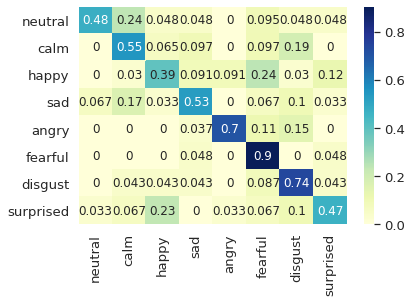

In [16]:
y_pred = trainer.predict(x_test, model, best_model_path)
print(emotions)
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
print(classification_report(y_test, y_pred))
cn = confusion_matrix(y_test, y_pred, normalize="true")
df_cm = pd.DataFrame(cn, index = [i for i in emotions.values()],
                  columns = [i for i in emotions.values()])
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="YlGnBu") # font size

plt.show()

# Berlin Database of Emotional Speech

In this part I train a model on a different database, the german "Berlin Database of Emotional Speech".

In [17]:
GER_audios = Path("German")

GER_em = {
    "W": 4,
    "E": 6,
    "A": 5,
    "F": 2,
    "T": 3,
    "N": 0
}
X_GER, y_GER = [], []
for file in GER_audios.glob("*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = basename[5]
    if emotion in GER_em.keys():
        emotion = GER_em[emotion] 
        # extract features
        features = extract_feature(file)

        X_GER.append(features)
        y_GER.append(emotion)
    
GER_e = [emotions[emotion] for emotion in y_GER]

In [18]:
x_train_GER, x_test_GER, y_train_GER, y_test_GER = train_test_split(X_GER, y_GER, test_size=0.15, random_state=3)
x_train_GER, x_val_GER, y_train_GER, y_val_GER = train_test_split(x_train_GER, y_train_GER, test_size=0.1765, random_state=3)
x_train_GER, x_test_GER, x_val_GER, y_train_GER, y_test_GER, y_val_GER = torch.Tensor(x_train_GER), torch.Tensor(x_test_GER), torch.Tensor(x_val_GER), torch.LongTensor(y_train_GER),  torch.LongTensor(y_test_GER), torch.LongTensor(y_val_GER)

Number of samples:  454


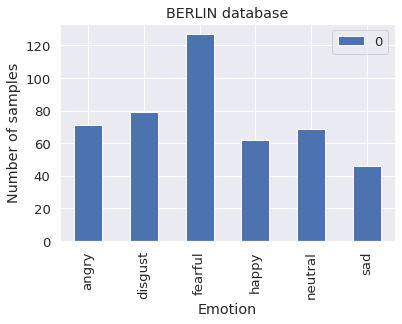

In [19]:
y_ct_GER = Counter(y_GER)
number_of_samples = len(y_GER)
print("Number of samples: ", number_of_samples)
keys = [emotions[y] for y in list(y_ct_GER.keys())]
data = y_ct_GER.values()
keys.sort()
to_plot= pd.DataFrame(data,index=keys)
to_plot.plot.bar()

plt.xlabel("Emotion")
plt.ylabel("Number of samples")
plt.title("BERLIN database")
plt.show()

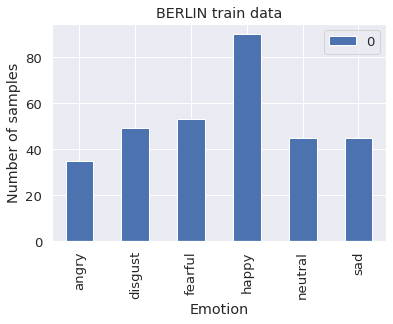

In [20]:
y_train_ct_GER = Counter(y_train_GER.tolist())

keys = [emotions[y] for y in list(y_train_ct_GER.keys())]
data = y_train_ct_GER.values()
keys.sort()
to_plot= pd.DataFrame(data,index=keys)
to_plot.plot.bar()

plt.xlabel("Emotion")
plt.ylabel("Number of samples")
plt.title("BERLIN train data")
plt.show()

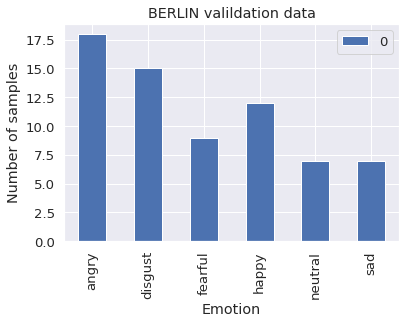

In [21]:
y_val_ct_GER = Counter(y_val_GER.tolist())

keys = [emotions[y] for y in list(y_val_ct_GER.keys())]
data = y_val_ct_GER.values()
keys.sort()
to_plot= pd.DataFrame(data,index=keys)
to_plot.plot.bar()

plt.xlabel("Emotion")
plt.ylabel("Number of samples")
plt.title("BERLIN valildation data")
plt.show()


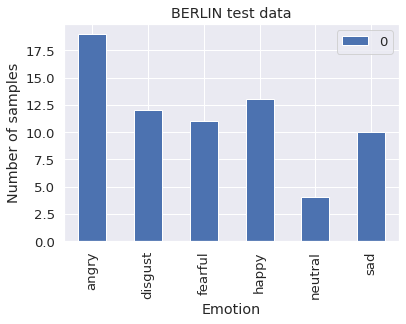

In [22]:
y_test_ct_GER = Counter(y_test_GER.tolist())

keys = [emotions[y] for y in list(y_test_ct_GER.keys())]
data = y_test_ct_GER.values()
keys.sort()
to_plot= pd.DataFrame(data,index=keys)
to_plot.plot.bar()

plt.xlabel("Emotion")
plt.ylabel("Number of samples")
plt.title("BERLIN test data")
plt.show()

In [23]:
output_size=len(list(emotions.keys()))
trainer.train_model(model, x_train_GER, y_train_GER, x_val_GER, y_val_GER, set_hyperparameters[2], 100, model_path=best_model_path)

pretrained model found
model3: Total loss in epoch 99 is: 0.01610766164958477      |      F1 score in validation is: 0.81072301632073929
 Finished training model3.


After the training I got the same matrices as for the initial RAVDESS dataset to evaluate the performance.

In [24]:
y_pred_GER = trainer.predict(x_test_GER, model, best_model_path)
pred_e_GER = [emotions[emotion] for emotion in y_pred_GER]

{0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
F1 Score: 0.735179229508152
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           2       0.62      0.62      0.62        13
           3       0.91      1.00      0.95        10
           4       0.68      0.89      0.77        19
           5       1.00      0.33      0.50        12
           6       0.50      0.50      0.50         4

    accuracy                           0.75        69
   macro avg       0.77      0.72      0.72        69
weighted avg       0.78      0.75      0.74        69



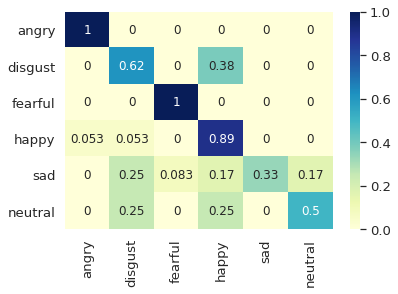

In [25]:
print(emotions)
print("F1 Score:", f1_score(y_test_GER, y_pred_GER, average="weighted"))
print(classification_report(y_test_GER, y_pred_GER))
cn = confusion_matrix(y_test_GER, y_pred_GER, normalize="true")
df_cm = pd.DataFrame(cn, index = [emotions[GER_em[i]] for i in GER_em.keys()],
                  columns = [emotions[GER_em[i]] for i in GER_em.keys()])
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="YlGnBu") # font size

plt.show()

The last tests are to see whether the additional training with the Berlin database improved the performance of the model on the RAVDESS data.

{0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
F1 Score: 0.16111490983068724
              precision    recall  f1-score   support

           0       0.14      0.48      0.22        21
           1       0.00      0.00      0.00        31
           2       0.50      0.36      0.42        33
           3       0.17      0.43      0.24        30
           4       0.00      0.00      0.00        27
           5       0.57      0.19      0.29        21
           6       0.11      0.17      0.14        23
           7       0.00      0.00      0.00        30

    accuracy                           0.20       216
   macro avg       0.19      0.20      0.16       216
weighted avg       0.18      0.20      0.16       216



/home/guspfame@GU.GU.SE/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


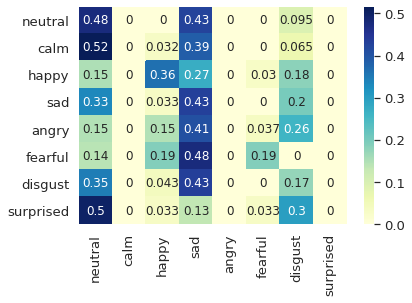

In [26]:
y_pred = trainer.predict(x_test, model, best_model_path)
print(emotions)
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
print(classification_report(y_test, y_pred))
cn = confusion_matrix(y_test, y_pred, normalize="true")
df_cm = pd.DataFrame(cn, index = [i for i in emotions.values()],
                  columns = [i for i in emotions.values()])
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="YlGnBu") # font size

plt.show()

# Demo

In this Demo I select a random file from the RAVDESS Corpus, play it and get the prediction for it.

In [27]:
all_files = Path("Audio_Speech_Actors_01-24")

In [28]:
audiofile = random.choice(list(all_files.glob("Actor_*/*.wav")))

In [29]:
IPython.display.Audio(audiofile)

In [30]:
x_random = extract_feature(audiofile)
x_random = torch.Tensor(x_random)
x_random = x_random.unsqueeze(0)
y_random = trainer.predict(x_random, model, best_model_path)
true_label = emotions[int(str(audiofile).split("-")[3][-1])-1]
predicted_label = emotions[y_random[0]]

In [31]:
predicted_label

'disgust'

In [32]:
true_label

'happy'

Demo for the Berlin database.

In [33]:
GER_files = Path("German")

In [34]:
audiofile = random.choice(list(GER_files.glob("*.wav")))

In [35]:
IPython.display.Audio(audiofile)

In [36]:
x_random = extract_feature(audiofile)
x_random = torch.Tensor(x_random)
x_random = x_random.unsqueeze(0)
y_random = trainer.predict(x_random, model, best_model_path)
true_label = emotions[GER_em[str(str(audiofile).split("/")[1])[5]]]
predicted_label = emotions[y_random[0]]

In [37]:
predicted_label

'happy'

In [38]:
true_label

'happy'